# Linear Regression
Reference: https://github.com/mml-book/mml-book.github.io/blob/master/tutorials/tutorial_linear_regression.solution.ipynb

1.1 Maximum Likelihood Estimation (MLE) for Linear regression

1.2 Polynomial Regression for Nonlinear features

1.3 Evaluating the Quality of the Model

2.1 Maximum A Posteriori Estimation (MAP)

2.2 LASSO Regression

3 Bayesian Linear Regression

Aim: Find good parameters $\theta$.
$$
y = \boldsymbol x^T\boldsymbol\theta + \epsilon\,,\quad \epsilon \sim \mathcal N(0, \sigma^2)
$$
where $\boldsymbol x\in\mathbb{R}^D$ are inputs and $y\in\mathbb{R}$ are noisy observations.

In [2]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import warnings
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LassoLarsCV, ElasticNetCV
from sklearn.exceptions import ConvergenceWarning
%matplotlib inline

### 1 Maximum Likelihood Estimation (MLE)
We find the parameters $\boldsymbol\theta^{\mathrm{ML}}$ that maximize the likelihood
$$
p(\mathcal Y | \mathcal X, \boldsymbol\theta) = \prod_{n=1}^N p(y_n | \boldsymbol x_n, \boldsymbol\theta)\,.
$$
The maximum likelihood estimator is given by
$$
\boldsymbol\theta^{\text{ML}} = (\boldsymbol X^T\boldsymbol X)^{-1}\boldsymbol X^T\boldsymbol y\in\mathbb{R}^D\,,
$$
where 
$$
\boldsymbol X = [\boldsymbol x_1, \ldots, \boldsymbol x_N]^T\in\mathbb{R}^{N\times D}\,,\quad y = \theta_0 + \boldsymbol x^T \boldsymbol\theta_1 + \epsilon\,,\quad \epsilon\sim\mathcal N(0,\sigma^2)
$$
$\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad$ If $\boldsymbol y = [y_1, \ldots, y_N]^T \in\mathbb{R}^N\,$, there's no intercept,
$\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad$ so to be inflexible when we predict with y+2

[[0.116]
 [0.499]]


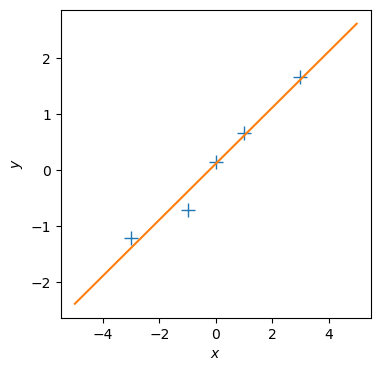

In [3]:
# Linear regression
# Augmented vector: y = x^𝑇_aug 𝜽_aug + 𝜖, 𝜽_aug=[𝜃_0 𝜽_1]^T, x_aug=[1 𝒙]^T.

X = np.array([-3, -1, 0, 1, 3]).reshape(-1,1) # 5x1 vector, N=5, D=1
y = np.array([-1.2, -0.7, 0.14, 0.67, 1.67]).reshape(-1,1) # 5x1 vector
Xtest = np.linspace(-5,5,100).reshape(-1,1)
N, D = X.shape
X_aug = np.hstack([np.ones((N,1)), X]) # augmented training inputs of size N x (D+1)
theta_aug = np.zeros((D+1, 1)) # new theta vector of size (D+1) x 1

def max_lik_estimate(X, y):
    
    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters (D x 1)

    N, D = X.shape
    theta_ml = np.linalg.solve(X.T @ X, X.T @ y)      # 1D vector: X.T @ y = np.dot(X.T, y)
    return theta_ml

def max_lik_estimate_aug(X_aug, y):
    
    theta_aug_ml = max_lik_estimate(X_aug, y)
    return theta_aug_ml

def predict_with_estimate(Xtest, theta):
    
    # Xtest: K x D matrix of test inputs
    # theta: D x 1 vector of parameters
    # returns: prediction of f(Xtest); K x 1 vector
    
    prediction = Xtest @ theta
    return prediction 

theta_aug_ml = max_lik_estimate_aug(X_aug, y)
print(theta_aug_ml)

Xtest_aug = np.hstack([np.ones((Xtest.shape[0],1)), Xtest]) # 100 x (D + 1) vector of test inputs
ml_prediction = predict_with_estimate(Xtest_aug, theta_aug_ml)
plt.figure(figsize=[4,4])
plt.plot(X, y, '+', markersize=10)
plt.plot(Xtest, ml_prediction)
plt.xlabel("$x$")
plt.ylabel("$y$");

#### 1.2 Polynomial Regression
One class of functions that is covered by linear regression is the family of polynomials because we can write a polynomial of degree $K$ as
$$
\sum_{k=0}^K \theta_k x^k = \boldsymbol \phi(x)^T\boldsymbol\theta\,,\quad
\boldsymbol\phi(x)= 
\begin{bmatrix}
x^0\\
x^1\\
\vdots\\
x^K
\end{bmatrix}\in\mathbb{R}^{K+1}\,.
$$
Here, $\boldsymbol\phi(x)$ is a nonlinear feature transformation of the inputs $x\in\mathbb{R}$.

Similar to the earlier case we can define a matrix that collects all the feature transformations of the training inputs:
$$
\boldsymbol\Phi = \begin{bmatrix}
\boldsymbol\phi(x_1) & \boldsymbol\phi(x_2) & \cdots & \boldsymbol\phi(x_n)
\end{bmatrix}^T \in\mathbb{R}^{N\times K+1}
$$
For reasons of numerical stability, we often add a small diagonal "jitter" $\kappa>0$ to $\boldsymbol\Phi^T\boldsymbol\Phi$ so that we can invert the matrix without significant problems so that the maximum likelihood estimate becomes
$$
\boldsymbol \theta^\text{ML} = (\boldsymbol\Phi^T\boldsymbol\Phi + \kappa\boldsymbol I)^{-1}\boldsymbol\Phi^T\boldsymbol y
$$
To make predictions at test inputs $\boldsymbol X_{\text{test}}\in\mathbb{R}$, we need to compute the features (nonlinear transformations) $\boldsymbol\Phi_{\text{test}}= \boldsymbol\phi(\boldsymbol X_{\text{test}})$ of $\boldsymbol X_{\text{test}}$ to give us the predicted mean
$$
\mathbb{E}[\boldsymbol y_{\text{test}}] = \boldsymbol \Phi_{\text{test}}\boldsymbol\theta^{\text{ML}}
$$

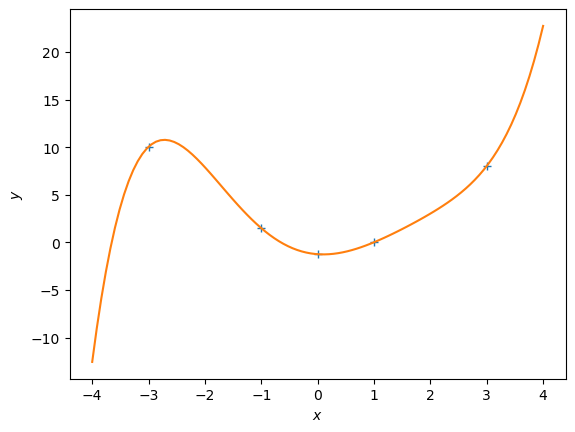

In [4]:
# Nonlinear regression
# 𝑓(x,𝜽)=∑(k=1,K)𝜃_k 𝜙_k(x), 𝜙_k(x) is (possibly nonlinear) transformations of the inputs x.
K = 5 # Define the degree of the polynomial we wish to fit

X = np.array([-3, -1, 0, 1, 3]).reshape(-1,1) # 5x1 vector
y = np.array([10.05, 1.5, -1.234, 0.02, 8.03]).reshape(-1,1)

def poly_features(X, K):
    
    # X: inputs of size N x 1
    # K: degree of the polynomial
    # computes the feature matrix Phi (N x (K+1))
    
    X = X.flatten()
    N = X.shape[0]
    Phi = np.zeros((N, K+1))
    
    for k in range(K+1):
        Phi[:,k] = X**k
    return Phi

def nonlinear_features_maximum_likelihood(Phi, y):
    
    # y: training targets. Size of N by 1
    # returns: maximum likelihood estimator theta_ml. Size of D x 1
    
    kappa = 1e-08 # 'jitter' term; good for numerical stability
    D = Phi.shape[1]  
    # maximum likelihood estimate
    Pt = Phi.T @ y # Phi^T*y
    PP = Phi.T @ Phi + kappa*np.eye(D) # Phi^T*Phi + kappa*I
    # maximum likelihood estimate
    C = scipy.linalg.cho_factor(PP)
    theta_ml = scipy.linalg.cho_solve(C, Pt) # inv(Phi^T*Phi)*Phi^T*y 
    return theta_ml

Phi = poly_features(X, K) # N x (K+1) feature matrix
theta_ml = nonlinear_features_maximum_likelihood(Phi, y) # maximum likelihood estimator
Xtest = np.linspace(-4,4,100).reshape(-1,1)
Phi_test = poly_features(Xtest, K)
y_pred = Phi_test @ theta_ml # predicted y-values

plt.figure()
plt.plot(X, y, '+')
plt.plot(Xtest, y_pred)
plt.xlabel("$x$")
plt.ylabel("$y$");

### Evaluating the Quality of the Model
Root-mean-squared-error (RMSE) between the $y$-values predicted by our polynomial and the ground-truth $y$-values. The RMSE is then defined as
$$
\text{RMSE} = \sqrt{\frac{1}{N}\sum_{n=1}^N(y_n - y_n^\text{pred})^2}
$$

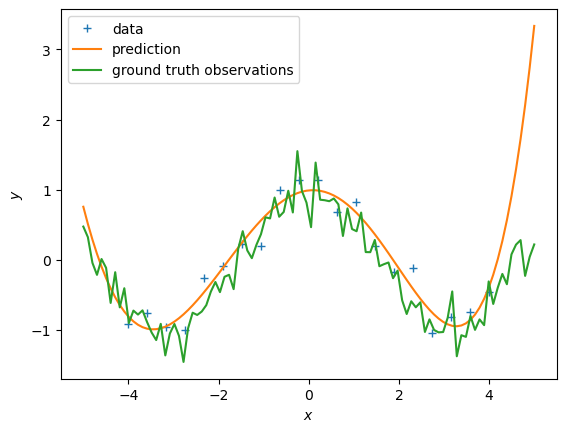

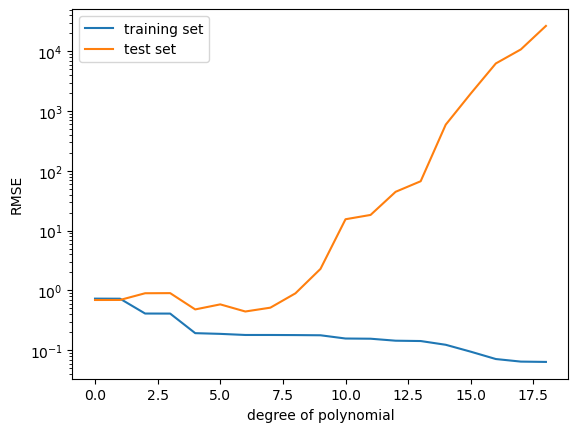

In [5]:
K = 5
K_max = 18

def f(x):   
    return np.cos(x) + 0.2*np.random.normal(size=(x.shape))

X = np.linspace(-4,4,20).reshape(-1,1)
y = f(X)
Xtest = np.linspace(-5,5,100).reshape(-1,1)
ytest = f(Xtest) # ground-truth y-values

Phi = poly_features(X, K) # N x (K+1) feature matrix
theta_ml = nonlinear_features_maximum_likelihood(Phi, y) # maximum likelihood estimator

Phi_test = poly_features(Xtest, K)
y_pred = Phi_test @ theta_ml

plt.figure()
plt.plot(X, y, '+')
plt.plot(Xtest, y_pred)
plt.plot(Xtest, ytest)
plt.legend(["data", "prediction", "ground truth observations"])
plt.xlabel("$x$")
plt.ylabel("$y$");

def RMSE(y, ypred):
    rmse = np.sqrt(np.mean((y-ypred)**2)) 
    return rmse

rmse_train = np.zeros((K_max+1,))
rmse_test = np.zeros((K_max+1,))

for k in range(K_max+1):
    # feature matrix
    Phi = poly_features(X, k)
    # maximum likelihood estimate
    theta_ml = nonlinear_features_maximum_likelihood(Phi, y)
    # predict y-values of training set
    ypred_train = Phi @ theta_ml
    # RMSE on training set
    rmse_train[k] = RMSE(y, ypred_train)    
    # feature matrix for test inputs
    Phi_test = poly_features(Xtest, k)
    # prediction
    ypred_test = Phi_test @ theta_ml
    # RMSE on test set
    rmse_test[k] = RMSE(ytest, ypred_test)

plt.figure()
plt.semilogy(rmse_train) # this plots the RMSE on a logarithmic scale
plt.semilogy(rmse_test) # this plots the RMSE on a logarithmic scale
plt.xlabel("degree of polynomial")
plt.ylabel("RMSE")
plt.legend(["training set", "test set"]);

### 2 Maximum A Posteriori Estimation (MAP)
We assume that the noise variance $\sigma^2$ is known.
$$
y = \boldsymbol\phi(\boldsymbol x)^T\boldsymbol\theta + \epsilon\,,\quad \epsilon\sim\mathcal N(0,\sigma^2)\,.
$$

Instead of maximizing the likelihood, we can look at the maximum of the posterior distribution on the parameters $\boldsymbol\theta$, which is given as
$$
p(\boldsymbol\theta|\mathcal X, \mathcal Y) = \frac{\overbrace{p(\mathcal Y|\mathcal X, \boldsymbol\theta)}^{\text{likelihood}}\overbrace{p(\boldsymbol\theta)}^{\text{prior}}}{\underbrace{p(\mathcal Y|\mathcal X)}_{\text{evidence}}}
$$
The purpose of the parameter prior $p(\boldsymbol\theta)$ is to discourage the parameters to attain extreme values, a sign that the model overfits. The prior allows us to specify a "reasonable" range of parameter values. Typically, we choose a Gaussian prior $\mathcal N(\boldsymbol 0, \alpha^2\boldsymbol I)$, centered at $\boldsymbol 0$ with variance $\alpha^2$ along each parameter dimension.

The MAP estimate of the parameters is
$$
\boldsymbol\theta^{\text{MAP}} = (\boldsymbol\Phi^T\boldsymbol\Phi + \frac{\sigma^2}{\alpha^2}\boldsymbol I)^{-1}\boldsymbol\Phi^T\boldsymbol y
$$
where $\sigma^2$ is the variance of the noise.

/var/folders/27/4f1j4j7d6954fp5b510nwz8c0000gn/T/ipykernel_33532/35537319.py:16: LinAlgWarning: Ill-conditioned matrix (rcond=1.82839e-17): result may not be accurate.
  theta_map = scipy.linalg.solve(PP, Phi.T @ y)


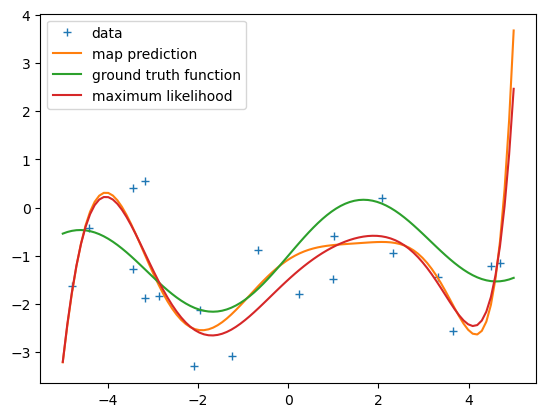

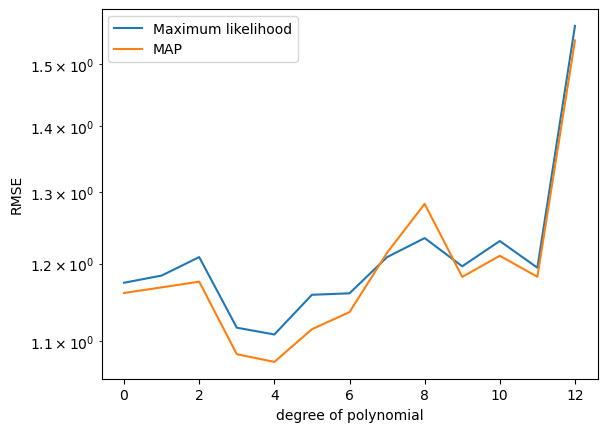

In [6]:
K = 8
K_max = 12
# assert(K_max < N)

sigma = 1.0 # noise standard deviation
alpha = 1.0 # standard deviation of the parameter prior
N = 20
np.random.seed(42)

def map_estimate_poly(Phi, y, sigma, alpha):
    # sigma: standard deviation of the noise 
    # alpha: standard deviation of the prior on the parameters
    
    D = Phi.shape[1] 
    PP = Phi.T @ Phi + (sigma/alpha)**2 * np.eye(D)
    theta_map = scipy.linalg.solve(PP, Phi.T @ y)
    return theta_map

# Generate data
def g(x, sigma):
    p = np.hstack([x**0, x**1, np.sin(x)])
    w = np.array([-1.0, 0.1, 1.0]).reshape(-1,1)
    return p @ w + sigma*np.random.normal(size=x.shape) 


X = (np.random.rand(N)*10.0 - 5.0).reshape(-1,1)
y = g(X, sigma)
Xtest = np.linspace(-5,5,100).reshape(-1,1)
ytest = g(Xtest, sigma)

Phi = poly_features(X, K)
theta_map = map_estimate_poly(Phi, y, sigma, alpha)
theta_ml = nonlinear_features_maximum_likelihood(Phi, y)

Phi_test = poly_features(Xtest, K)
y_pred_map = Phi_test @ theta_map
y_pred_mle = Phi_test @ theta_ml

plt.figure()
plt.plot(X, y, '+')
plt.plot(Xtest, y_pred_map)
plt.plot(Xtest, g(Xtest, 0))
plt.plot(Xtest, y_pred_mle)

plt.legend(["data", "map prediction", "ground truth function", "maximum likelihood"]);


rmse_mle = np.zeros((K_max+1,))
rmse_map = np.zeros((K_max+1,))

for k in range(K_max+1):
    Phi = poly_features(X, k)
    theta_ml = nonlinear_features_maximum_likelihood(Phi, y)
    y_pred_test = 0*Xtest 
    Phi_test = poly_features(Xtest, k)
    ypred_test_mle = Phi_test @ theta_ml
    rmse_mle[k] = RMSE(ytest, ypred_test_mle)
    
    theta_map = map_estimate_poly(Phi, y, sigma, alpha)
    Phi_test = poly_features(Xtest, k)
    ypred_test_map = Phi_test @ theta_map
    rmse_map[k] = RMSE(ytest, ypred_test_map)
    
plt.figure()
plt.semilogy(rmse_mle)
plt.semilogy(rmse_map)
plt.xlabel("degree of polynomial")
plt.ylabel("RMSE")
plt.legend(["Maximum likelihood", "MAP"])

### 2.2 LASSO Regression as MAP Estimation with a Laplace Prior

To encourage $\boldsymbol{sparsity}$ in the parameters, we choose a Laplace prior (double-exponential distribution) for each coefficient:
$$
p(\boldsymbol\theta) \;=\; \prod_{j=1}^D \frac{1}{2b}\,\exp\!\left(-\frac{|\theta_j|}{b}\right),
$$
where $b>0$ controls the concentration of the prior around zero.

Maximizing the posterior is equivalent to minimizing the following LASSO-regularized least squares objective:
$$
\boldsymbol\theta^{\mathrm{MAP}}
\;=\;
\arg\min_{\boldsymbol\theta}\;
\frac{1}{2\sigma^2}\,\|\boldsymbol y-\boldsymbol\Phi\boldsymbol\theta\|_2^2
\;+\; \frac{1}{b}\,\|\boldsymbol\theta\|_1.
$$
We set $\lambda = \frac{1}{b}$ if needed.

Unlike the Gaussian prior (Ridge regression), the Laplace prior leads to an $\ell_1$ penalty, which can drive some coefficients exactly to zero, resulting in a sparse solution. This optimization problem has no closed-form solution and is typically solved via numerical methods such as coordinate descent, proximal gradient (ISTA/FISTA), or the LARS algorithm.

/var/folders/27/4f1j4j7d6954fp5b510nwz8c0000gn/T/ipykernel_33532/35537319.py:16: LinAlgWarning: Ill-conditioned matrix (rcond=1.82839e-17): result may not be accurate.
  theta_map = scipy.linalg.solve(PP, Phi.T @ y)


[-1.47779446  1.2152957   0.14981671 -2.23929128  0.         -0.
 -0.          0.         -0.          0.         -0.          1.14189642
 -0.        ]


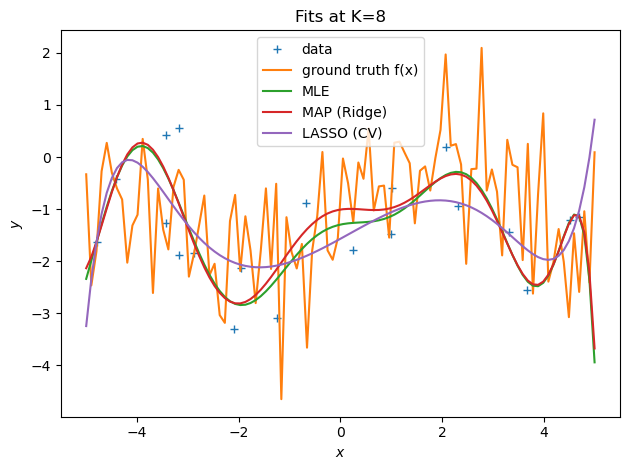

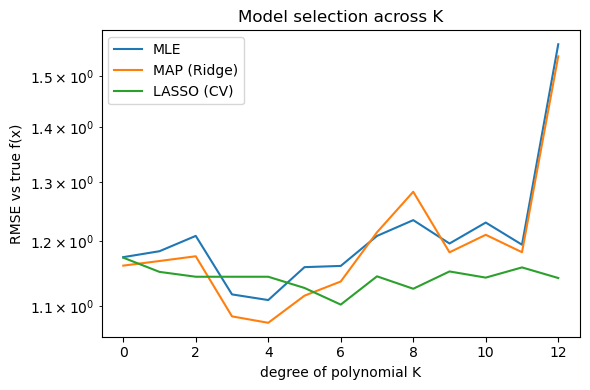

In [9]:
# LASSO_ElasticNetCV (Choice of LassoCV / ElasticNetCV / LassoLarsCV see below)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    lasso_pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=False, with_std=True)),
        ("model", ElasticNetCV(
            l1_ratio=[0.3,0.5,0.7,0.9],
            alphas=np.logspace(-6,0,60),
            cv=3, fit_intercept=False,
            max_iter=1_000_000, tol=1e-6, n_jobs=-1))
    ]).fit(Phi, y.ravel())
y_lasso = lasso_pipe.predict(Phi_test).reshape(-1,1)


# MLE
theta_ml  = nonlinear_features_maximum_likelihood(Phi, y)
y_mle     = Phi_test @ theta_ml

# MAP (Ridge)
theta_map = map_estimate_poly(Phi, y, sigma, alpha)
y_map     = Phi_test @ theta_map

plt.figure()
plt.plot(X, y, '+', label="data")
plt.plot(Xtest, ytest, label="ground truth f(x)")
plt.plot(Xtest, y_mle, label="MLE")
plt.plot(Xtest, y_map, label="MAP (Ridge)")
plt.plot(Xtest, y_lasso, label="LASSO (CV)")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title(f"Fits at K={K}")
plt.tight_layout();

# Evaluation
rmse_mle   = np.zeros(K_max+1)
rmse_map   = np.zeros(K_max+1)
rmse_lasso = np.zeros(K_max+1)

for k in range(K_max+1):
    Phi      = poly_features(X, k)
    Phi_test = poly_features(Xtest, k)
    # MLE
    theta_ml = nonlinear_features_maximum_likelihood(Phi, y)
    rmse_mle[k] = RMSE(ytest, Phi_test @ theta_ml)
    # MAP (Ridge)
    theta_map = map_estimate_poly(Phi, y, sigma, alpha)
    rmse_map[k] = RMSE(ytest, Phi_test @ theta_map)
    # LASSO
    lasso_pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=False, with_std=True)),
        ("model", ElasticNetCV(l1_ratio=[0.3,0.5,0.7,0.9],
                           alphas=np.logspace(-6,0,60),
                           cv=3, fit_intercept=False,
                           max_iter=1_000_000, tol=1e-6, n_jobs=-1))
    ]).fit(Phi, y.ravel())
    yhat = lasso_pipe.predict(Phi_test).reshape(-1,1)
    rmse_lasso[k] = RMSE(ytest, yhat)

plt.figure(figsize=(6,4))
plt.semilogy(rmse_mle,   label="MLE")
plt.semilogy(rmse_map,   label="MAP (Ridge)")
plt.semilogy(rmse_lasso, label="LASSO (CV)")
plt.xlabel("degree of polynomial K")
plt.ylabel("RMSE vs true f(x)")
plt.legend()
plt.title("Model selection across K")
plt.tight_layout();

coef = lasso_pipe.named_steps["model"].coef_
print(coef)

In [ ]:
# LassoCV, LassoLarsCV or ElasticNetCV, please find the principal difference in notion
# Way I: Lasso
lasso_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False, with_std=True)),  # 常数列在！不要居中
    ("model",  LassoCV(
        alphas=np.logspace(-7, 0, 160),  # 覆盖更小的正则
        cv=5,
        fit_intercept=False,             # 有常数列就关掉截距
        max_iter=1_000_000,              # 抬高迭代上限
        tol=1e-7,                        # 更严格的容差；也可 1e-6
        selection="random",              # 随机坐标更新，常更快收敛
        n_jobs=-1,
        random_state=0
    ))
])

# Way II: LassoLarsCV
lars = Pipeline([
    ("scaler", StandardScaler(with_mean=False, with_std=True)),
    ("model",  LassoLarsCV(cv=5, fit_intercept=False, max_iter=10_000, n_jobs=-1))
])

# Way III: ElasticNetCV
enet = Pipeline([
    ("scaler", StandardScaler(with_mean=False, with_std=True)),
    ("model", ElasticNetCV(l1_ratio=[0.3,0.5,0.7,0.9],
                           alphas=np.logspace(-6,0,60),
                           cv=3, fit_intercept=False,
                           max_iter=1_000_000, tol=1e-6, n_jobs=-1))
]).fit(Phi, y.ravel())

### 3 Bayesian Linear Regression
Assume a parameter prior $p(\boldsymbol\theta) = \mathcal N (\boldsymbol 0, \alpha^2\boldsymbol I)$. For every test input $\boldsymbol x_*$ we obtain the 
prior mean
$$
E[f(\boldsymbol x_*)] = 0
$$
and the prior (marginal) variance (ignoring the noise contribution)
$$
V[f(\boldsymbol x_*)] = \alpha^2\boldsymbol\phi(\boldsymbol x_*) \boldsymbol\phi(\boldsymbol x_*)^\top
$$
where $\boldsymbol\phi(\cdot)$ is the feature map.

Every sampled function is a polynomial of degree 3


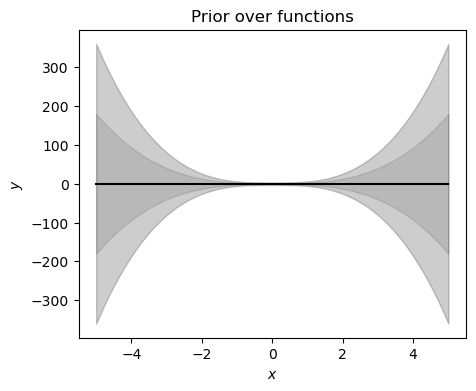

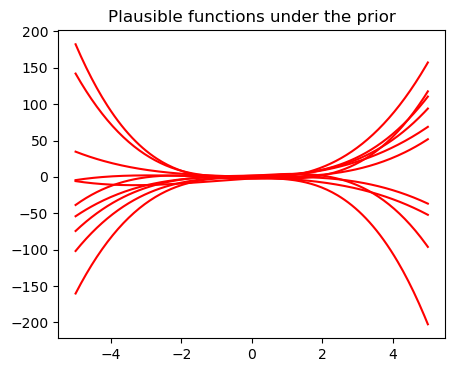

In [17]:
Ntest = 200
Xtest = np.linspace(-5, 5, Ntest).reshape(-1,1) # test inputs

prior_var = 2.0 # variance of the parameter prior (alpha^2). We assume this is known.
noise_var = 1.0 # noise variance (sigma^2). We assume this is known.

pol_deg = 3 # degree of the polynomial we consider at the moment

Phi_test = poly_features(Xtest, pol_deg) # N x (pol_deg+1) feature matrix
prior_mean = np.zeros((Ntest,1))
full_covariance = Phi_test @ Phi_test.T * prior_var # N x N covariance matrix of all function values
prior_marginal_var =  np.diag(full_covariance)

plt.figure(figsize=[5,4])
plt.plot(Xtest, prior_mean, color="k")

conf_bound1 = np.sqrt(prior_marginal_var).flatten()
conf_bound2 = 2.0*np.sqrt(prior_marginal_var).flatten()
conf_bound3 = 2.0*np.sqrt(prior_marginal_var + noise_var).flatten()
plt.fill_between(Xtest.flatten(), prior_mean.flatten() + conf_bound1, 
             prior_mean.flatten() - conf_bound1, alpha = 0.1, color="k")
plt.fill_between(Xtest.flatten(), prior_mean.flatten() + conf_bound2, 
                 prior_mean.flatten() - conf_bound2, alpha = 0.1, color="k")
plt.fill_between(Xtest.flatten(), prior_mean.flatten() + conf_bound3, 
                 prior_mean.flatten() - conf_bound3, alpha = 0.1, color="k")

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Prior over functions");


num_samples = 10
random_weights = np.random.normal(size=(pol_deg+1,num_samples), scale=np.sqrt(prior_var))
sample_function = Phi_test @ random_weights

plt.figure(figsize=[5,4])
plt.plot(Xtest, sample_function, color="r")
plt.title("Plausible functions under the prior")
print("Every sampled function is a polynomial of degree "+str(pol_deg));

Now, let's make predictions (ignoring the measurement noise). We obtain three predictors:
\begin{align}
&\text{Maximum likelihood: }E[f(\boldsymbol X_{\text{test}})] = \boldsymbol \phi(X_{\text{test}})\boldsymbol \theta_{ml}\\
&\text{Maximum a posteriori: } E[f(\boldsymbol X_{\text{test}})] = \boldsymbol \phi(X_{\text{test}})\boldsymbol \theta_{map}\\
&\text{Bayesian: } p(f(\boldsymbol X_{\text{test}})) = \mathcal N(f(\boldsymbol X_{\text{test}}) \,|\, \boldsymbol \phi(X_{\text{test}}) \boldsymbol\theta_{\text{mean}},\, \boldsymbol\phi(X_{\text{test}}) \boldsymbol\theta_{\text{var}}  \boldsymbol\phi(X_{\text{test}})^\top)
\end{align}
We already computed all quantities. Write some code that implements all three predictors.

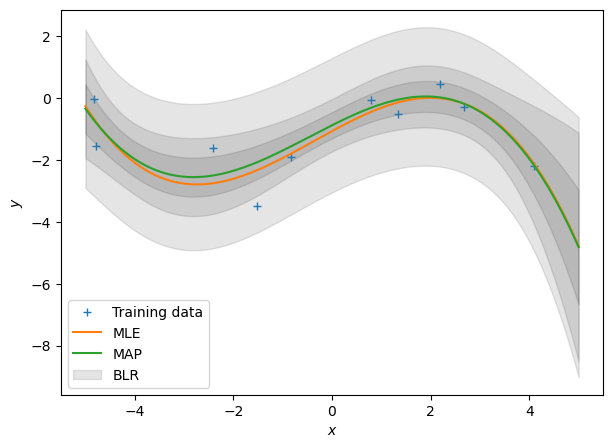

In [21]:
# Training inputs
N = 10
X = np.random.uniform(high=5, low=-5, size=(N,1)) 
y = g(X, np.sqrt(noise_var))

def polyfit(X, y, K, prior_var, noise_var):
    # X: training inputs, size N x D
    # y: training targets, size N x 1
    # K: degree of polynomial we consider
    # prior_var: prior variance of the parameter distribution
    # sigma: noise variance
    
    jitter = 1e-08 # increases numerical stability
    
    Phi = poly_features(X, K) # N x (K+1) feature matrix 
    
    # Compute maximum likelihood estimate
    Pt = Phi.T @ y # Phi*y, size (K+1,1)
    PP = Phi.T @ Phi + jitter*np.eye(K+1) # size (K+1, K+1)
    C = scipy.linalg.cho_factor(PP)
    # maximum likelihood estimate
    theta_ml = scipy.linalg.cho_solve(C, Pt) # inv(Phi^T*Phi)*Phi^T*y, size (K+1,1)
    
#     theta_ml = scipy.linalg.solve(PP, Pt) # inv(Phi^T*Phi)*Phi^T*y, size (K+1,1)
    
    # MAP estimate
    theta_map = scipy.linalg.solve(PP + noise_var/prior_var*np.eye(K+1), Pt)
    
    # parameter posterior
    iSN = (np.eye(K+1)/prior_var + PP/noise_var) # posterior precision
    SN = scipy.linalg.pinv(noise_var*np.eye(K+1)/prior_var + PP)*noise_var  # posterior covariance
    mN = scipy.linalg.solve(iSN, Pt/noise_var) # posterior mean
    
    return (theta_ml, theta_map, mN, SN)

theta_ml, theta_map, theta_mean, theta_var = polyfit(X, y, pol_deg, alpha, sigma)

Phi_test = poly_features(Xtest, pol_deg) # N x (K+1)
m_mle_test = Phi_test @ theta_ml
m_map_test = Phi_test @ theta_map
mean_blr = Phi_test @ theta_mean
cov_blr =  Phi_test @ theta_var @ Phi_test.T

plt.figure(figsize=[7,5])
plt.plot(X, y, "+")
plt.plot(Xtest, m_mle_test)
plt.plot(Xtest, m_map_test)
var_blr = np.diag(cov_blr)
conf_bound1 = np.sqrt(var_blr).flatten()               # ±1σ
conf_bound2 = 2.0*np.sqrt(var_blr).flatten()           # ±2σ
conf_bound3 = 2.0*np.sqrt(var_blr + sigma).flatten()   # + σ_noise

plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound1, 
                 mean_blr.flatten() - conf_bound1, alpha = 0.1, color="k")
plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound2, 
                 mean_blr.flatten() - conf_bound2, alpha = 0.1, color="k")
plt.fill_between(Xtest.flatten(), mean_blr.flatten() + conf_bound3, 
                 mean_blr.flatten() - conf_bound3, alpha = 0.1, color="k")
plt.legend(["Training data", "MLE", "MAP", "BLR"])
plt.xlabel('$x$');
plt.ylabel('$y$');